# Post processing code for 2-LidDrivenCavity-Bingham.c


This notebook visualizes the results from the 2-LidDrivenCavity-Bingham.c simulation.
It processes and plots:
- Strain rate (D2) distribution - showing yielded (colored) vs. unyielded (black) regions
- Velocity field and streamlines - showing flow patterns
- Comparison across different yield stress values ($\tau_y$)

The simulation models a square cavity with a moving top lid, demonstrating how 
Bingham fluids (yield-stress fluids) behave differently from Newtonian fluids,
particularly in forming unyielded (solid-like) regions where stress is below yield stress.


In [1]:
import numpy as np
import os
import subprocess as sp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.ticker import StrMethodFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

def gettingfield(filename, zmin, zmax, rmin, rmax, nr):
    exe = ["./getData-LidDriven", filename, str(zmin), str(rmin), str(zmax), str(rmax), str(nr)]
    p = sp.Popen(exe, stdout=sp.PIPE, stderr=sp.PIPE)
    stdout, stderr = p.communicate()
    temp1 = stderr.decode("utf-8")
    temp2 = temp1.split("\n")
    # print(temp2) #debugging
    Rtemp, Ztemp, D2temp, veltemp, Psitemp  = [],[],[],[], []

    for n1 in range(len(temp2)):
        temp3 = temp2[n1].split(" ")
        if temp3 == ['']:
            pass
        else:
            Ztemp.append(float(temp3[0]))
            Rtemp.append(float(temp3[1]))
            D2temp.append(float(temp3[2]))
            veltemp.append(float(temp3[3]))
            Psitemp.append(float(temp3[4]))
    R = np.asarray(Rtemp)
    Z = np.asarray(Ztemp)
    D2 = np.asarray(D2temp)
    vel = np.asarray(veltemp)
    psi = np.asarray(Psitemp)
    nz = int(len(Z)/nr)

    # print("nr is %d %d" % (nr, len(R))) # debugging
    print("nz is %d" % nz)

    R.resize((nz, nr))
    Z.resize((nz, nr))
    D2.resize((nz, nr))
    vel.resize((nz, nr))
    psi.resize((nz, nr))

    # rotate the arrays by 90 degrees
    R = np.rot90(R, k=1)
    Z = np.rot90(Z, k=1)
    D2 = np.rot90(D2, k=1)
    vel = np.rot90(vel, k=1)
    psi = np.rot90(psi, k=1)

    # flip the array
    R = np.flip(R, axis=0)
    Z = np.flip(Z, axis=0)
    D2 = np.flip(D2, axis=0)
    vel = np.flip(vel, axis=0)
    psi = np.flip(psi, axis=0)

    return R, Z, D2, vel, psi, nz
# ----------------------------------------------------------------------------------------------------------------------

In [2]:
def process_timestep(caseToProcess, GridsPerR, rmin, rmax, zmin, zmax, lw, tau0):
    """
    Process and visualize a single timestep of the lid-driven cavity simulation.
    
    This function loads simulation data from a specified case file, processes the data,
    and creates a visualization with two subplots: one showing the rate of strain tensor
    and another showing the velocity magnitude. Both plots include streamlines.
    
    Parameters:
    -----------
    caseToProcess : str
        Path to the simulation data file
    GridsPerR : int
        Number of grid points per unit length in the r-direction
    rmin, rmax : float
        Minimum and maximum r-coordinates for the plot
    zmin, zmax : float
        Minimum and maximum z-coordinates for the plot
    lw : int
        Line width for the domain boundaries
    tau0 : float
        Yield stress value for the title
    
    Returns:
    --------
    None
        Displays the visualization plot
    """
    # Define the path to the case file
    place = f"{caseToProcess}"

    # Check if the file exists
    if not os.path.exists(place):
        print(f"{place} File not found!")
        return
    
    # Calculate number of grid points in r-direction based on domain size
    nr = int(GridsPerR * rmax)
    
    # Extract field data from the simulation file
    R, Z, D2, vel, psi, nz = gettingfield(place, zmin, zmax, rmin, rmax, nr)
    
    # Get actual domain bounds from the data
    zminp, zmaxp, rminp, rmaxp = Z.min(), Z.max(), R.min(), R.max()

    # Set up the figure with two subplots
    AxesLabel, TickLabel = 50, 20
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 11), constrained_layout=True)

    # First subplot - Rate of Strain Tensor (D2)
    # Draw domain boundaries
    ax1.plot([rmin, rmin], [zmin, zmax], '-', color='black', linewidth=lw)
    ax1.plot([rmin, rmax], [zmin, zmin], '-', color='black', linewidth=lw)
    ax1.plot([rmin, rmax], [zmax, zmax], '-', color='black', linewidth=lw)
    ax1.plot([rmax, rmax], [zmin, zmax], '-', color='black', linewidth=lw)

    # Plot the rate of strain tensor with a heat map
    cntrl1 = ax1.pcolormesh(Z, R, D2, cmap="hot", edgecolor='face', vmax=1, vmin=-5)
    
    # Add streamlines using the stream function
    ax1.contour(Z, R, psi, 20, colors='black', linewidths=2)

    # Configure the first subplot
    ax1.set_aspect('equal')
    ax1.set_xlim(rmin, rmax)
    ax1.set_ylim(zmin, zmax)
    ax1.set_title(r'Rate of Strain Tensor', fontsize=TickLabel)

    # Add colorbar to the first subplot
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.1)
    c1 = plt.colorbar(cntrl1, cax=cax1)
    c1.set_label(r'$log_{10}(\|\mathcal{D}_{ij}\|)$', fontsize=TickLabel, labelpad=5)
    c1.ax.tick_params(labelsize=TickLabel)

    # Second subplot - Velocity Magnitude
    # Draw domain boundaries
    ax2.plot([rmin, rmin], [zmin, zmax], '-', color='black', linewidth=lw)
    ax2.plot([rmin, rmax], [zmin, zmin], '-', color='black', linewidth=lw)
    ax2.plot([rmin, rmax], [zmax, zmax], '-', color='black', linewidth=lw)
    ax2.plot([rmax, rmax], [zmin, zmax], '-', color='black', linewidth=lw)

    # Plot velocity magnitude with viridis colormap
    cntrl2 = ax2.pcolormesh(Z, R, vel, cmap="viridis", edgecolor='face', vmax = 1, vmin = 0)
    
    # Add streamlines using the stream function
    ax2.contour(Z, R, psi, 20, colors='black', linewidths=2)

    # Configure the second subplot
    ax2.set_aspect('equal')
    ax2.set_xlim(rmin, rmax)
    ax2.set_ylim(zmin, zmax)
    ax2.set_title(r'Velocity Magnitude', fontsize=TickLabel)

    # Add colorbar to the second subplot
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="5%", pad=0.1)
    c2 = plt.colorbar(cntrl2, cax=cax2)
    c2.set_label(r'Velocity', fontsize=TickLabel, labelpad=5)
    c2.ax.tick_params(labelsize=TickLabel)

    # Add a common title for the entire figure
    fig.suptitle(f'Lid-driven Cavity, $\\tau_0 = {tau0}$', fontsize=TickLabel+5, y=1.01)

    # Turn off axes for cleaner visualization
    ax1.axis('off')
    ax2.axis('off')
    plt.savefig(f'2-LidDrivenCavity-Bingham-Data/tau{tau0}.pdf', bbox_inches='tight')
    # Display the figure
    plt.show()

nz is 128


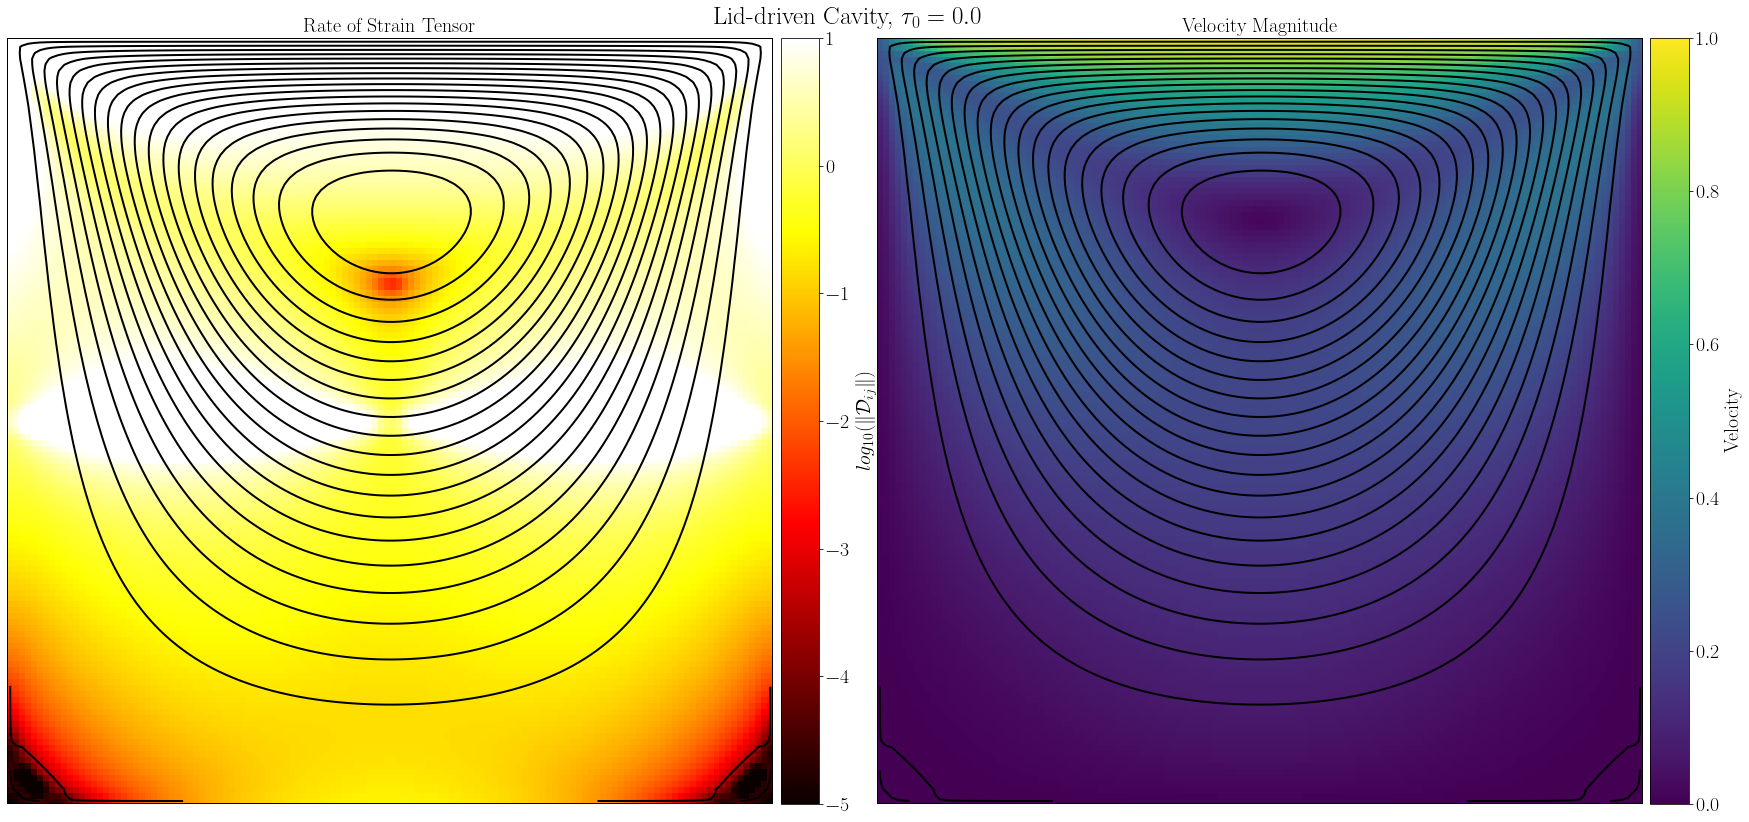

nz is 128


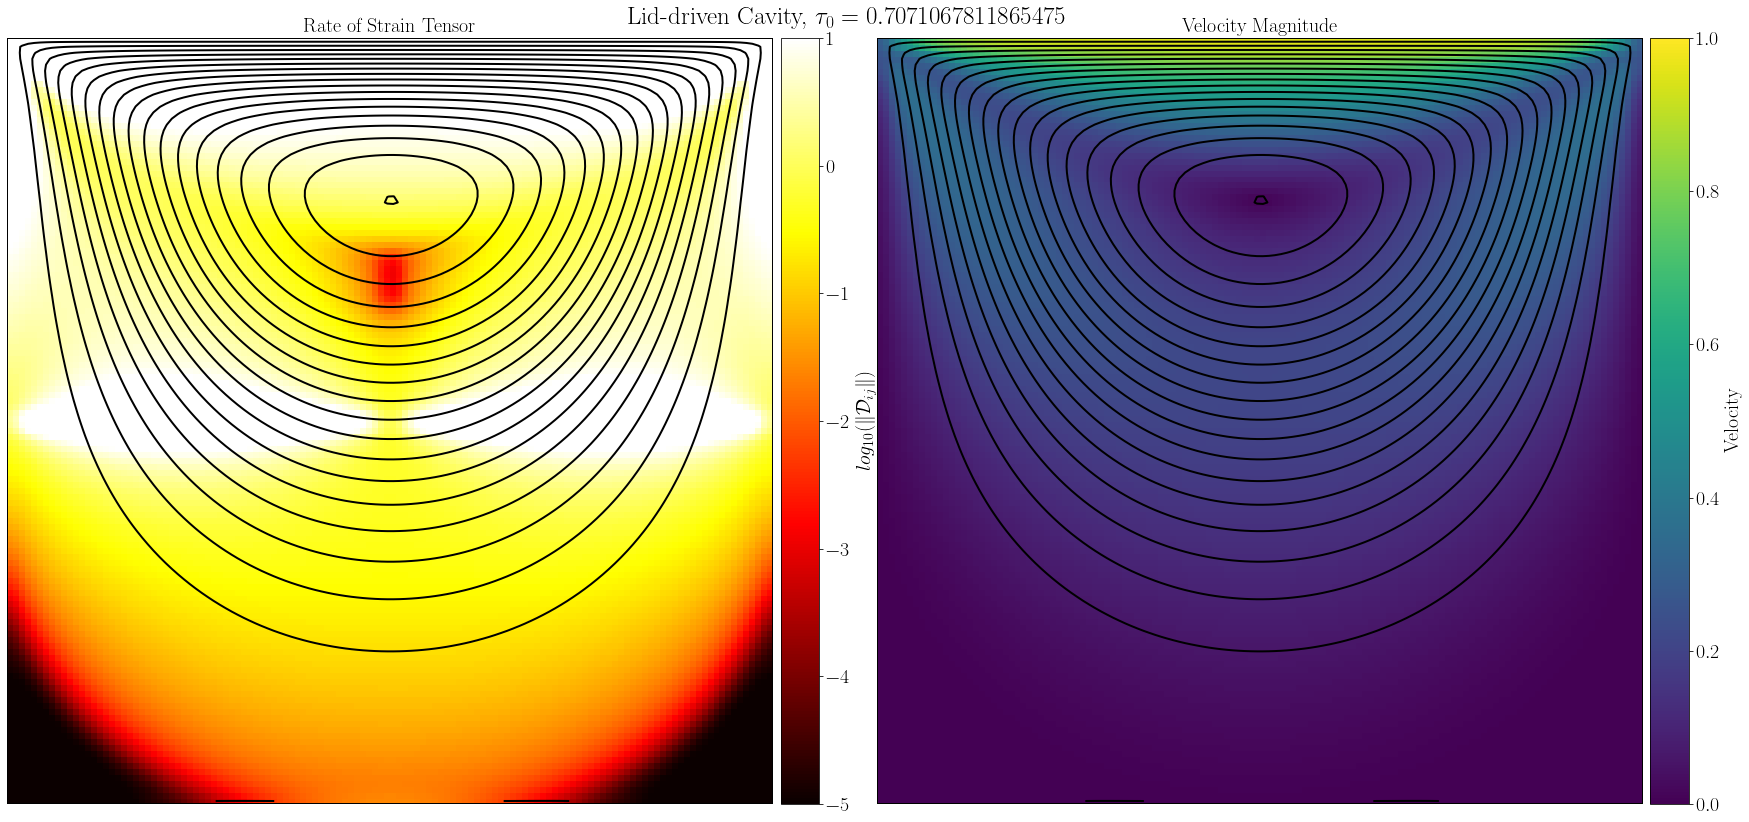

nz is 128


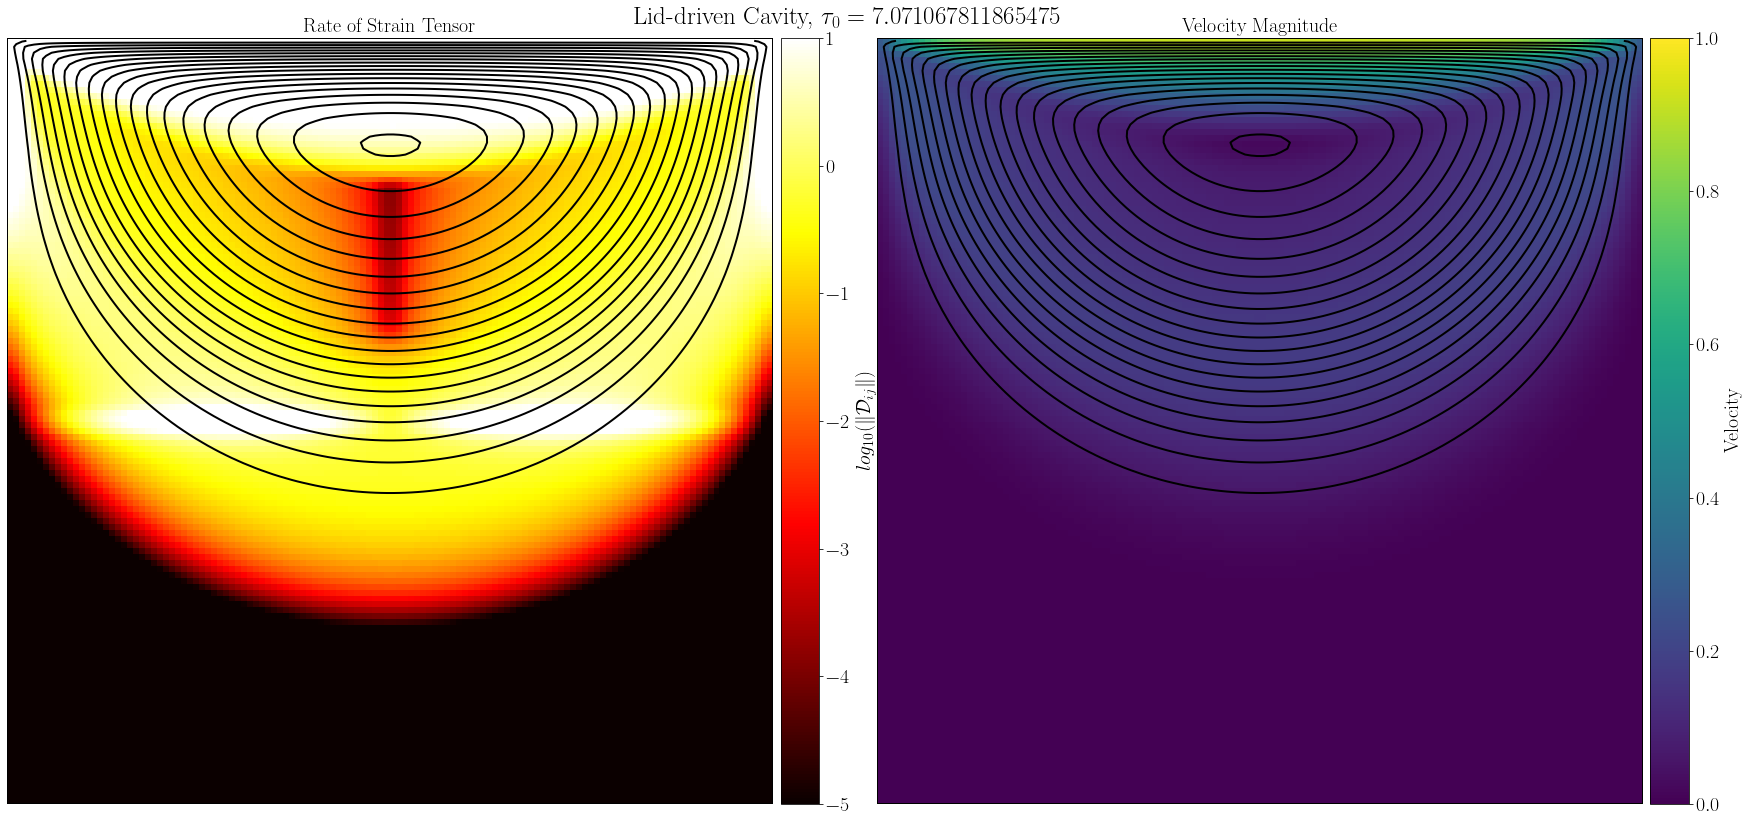

nz is 128


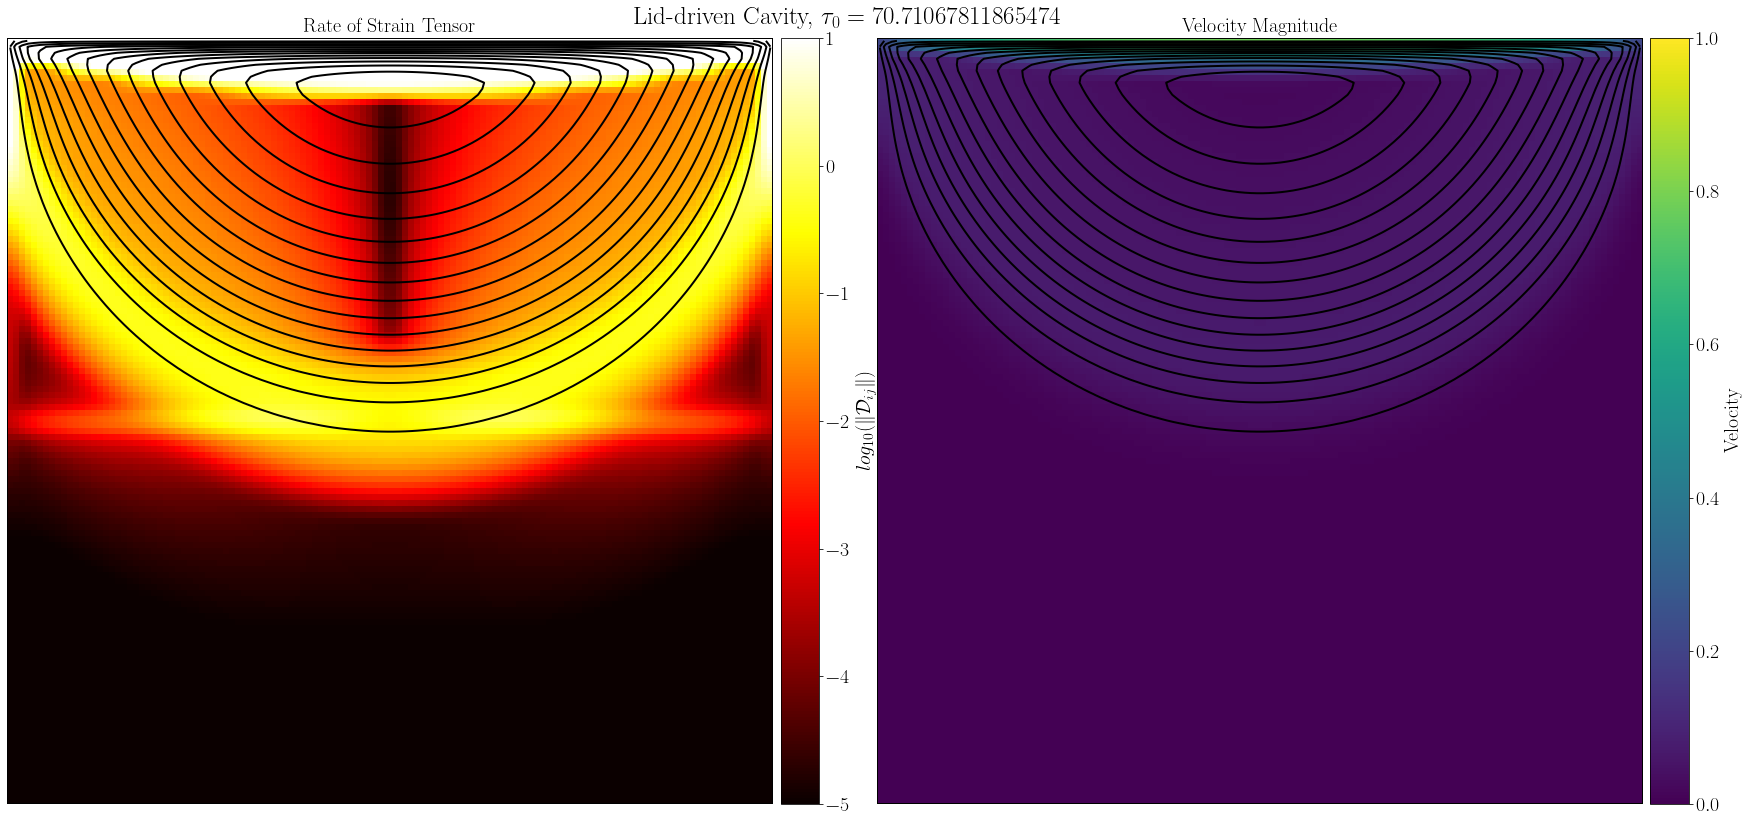

nz is 128


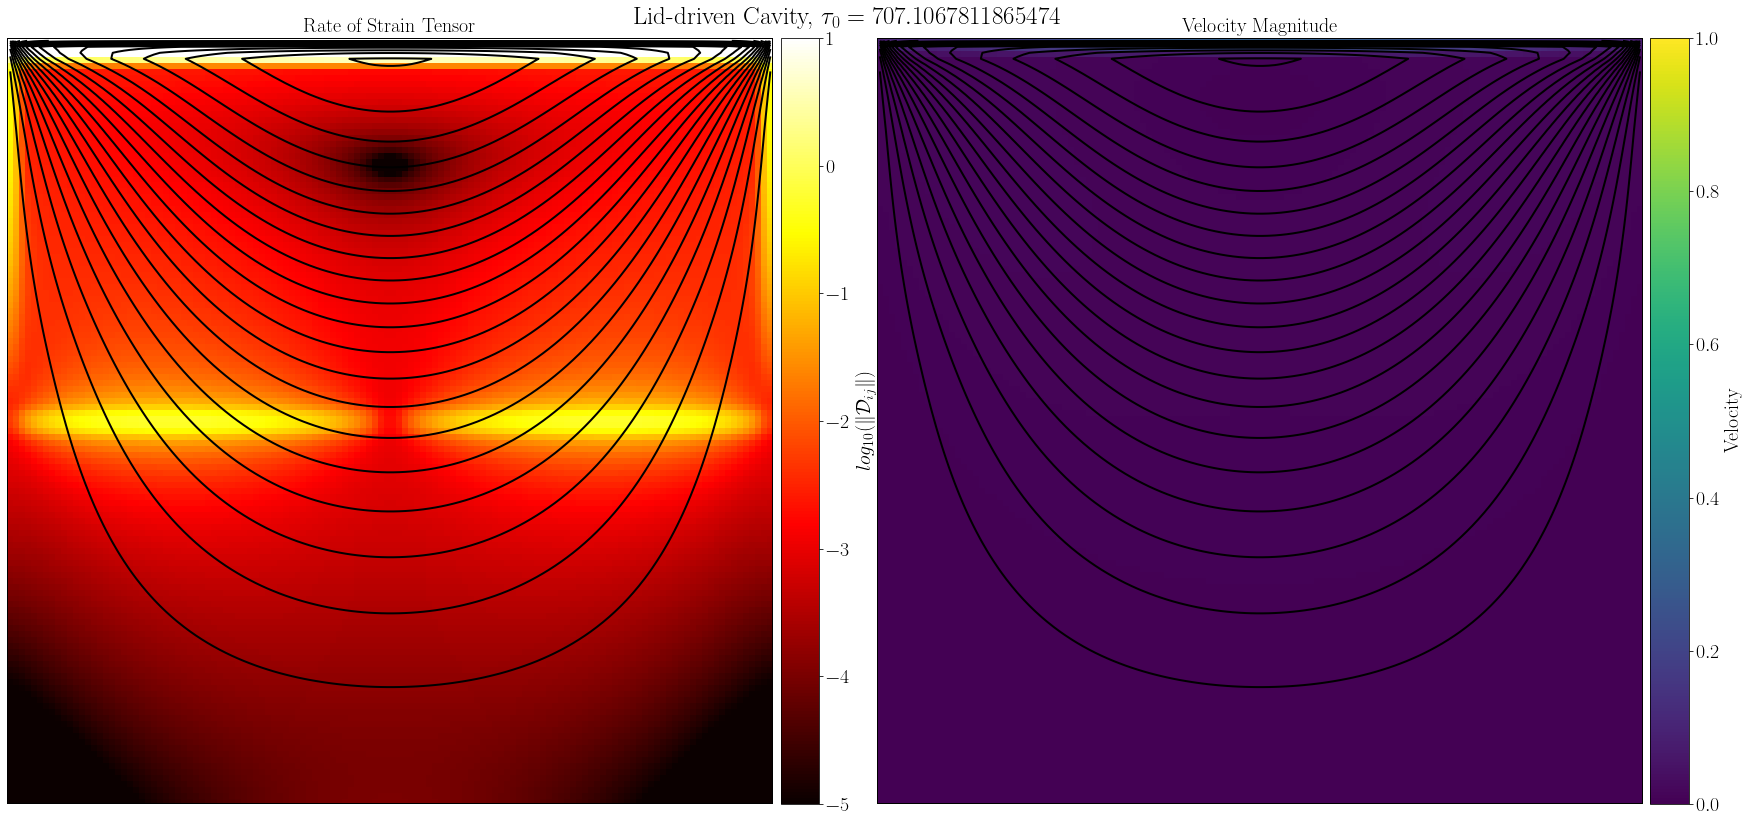

In [3]:
for counter in range(5):
  if counter == 0:
      tauy = 0.0  # Newtonian case
  else:
      tauy = 10**(counter-1)/np.sqrt(2)
  process_timestep(caseToProcess=f"../testCases/2-LidDrivenCavity-Bingham/2-LidDrivenCavity-Bingham-tau{counter}", GridsPerR=256, rmin=-0.5, rmax=0.5, zmin=-0.5, zmax=0.5, lw=2, tau0=tauy)

### Quantitative Comparison of Bingham Fluid Models

This section compares velocity profiles along the vertical centerline for different yield stress values:
- Basilisk C implementation (current simulation)
- Augmented Lagrangian Method (Popinet)
- Vola et al. (2003) benchmark results

The comparison includes five different yield stress values (τ_y): 0, 1/√2, 10/√2, 100/√2, and 1000/√2.
Results are visualized with distinct colors for each yield stress value, showing excellent agreement
between the current implementation and established methods.

Reference: D. Vola, L. Boscardin & J. Latché, Laminar unsteady flows of Bingham fluids: a numerical strategy and some benchmark results, J. Comput. Phys., 187:2, 441-456 (2003)


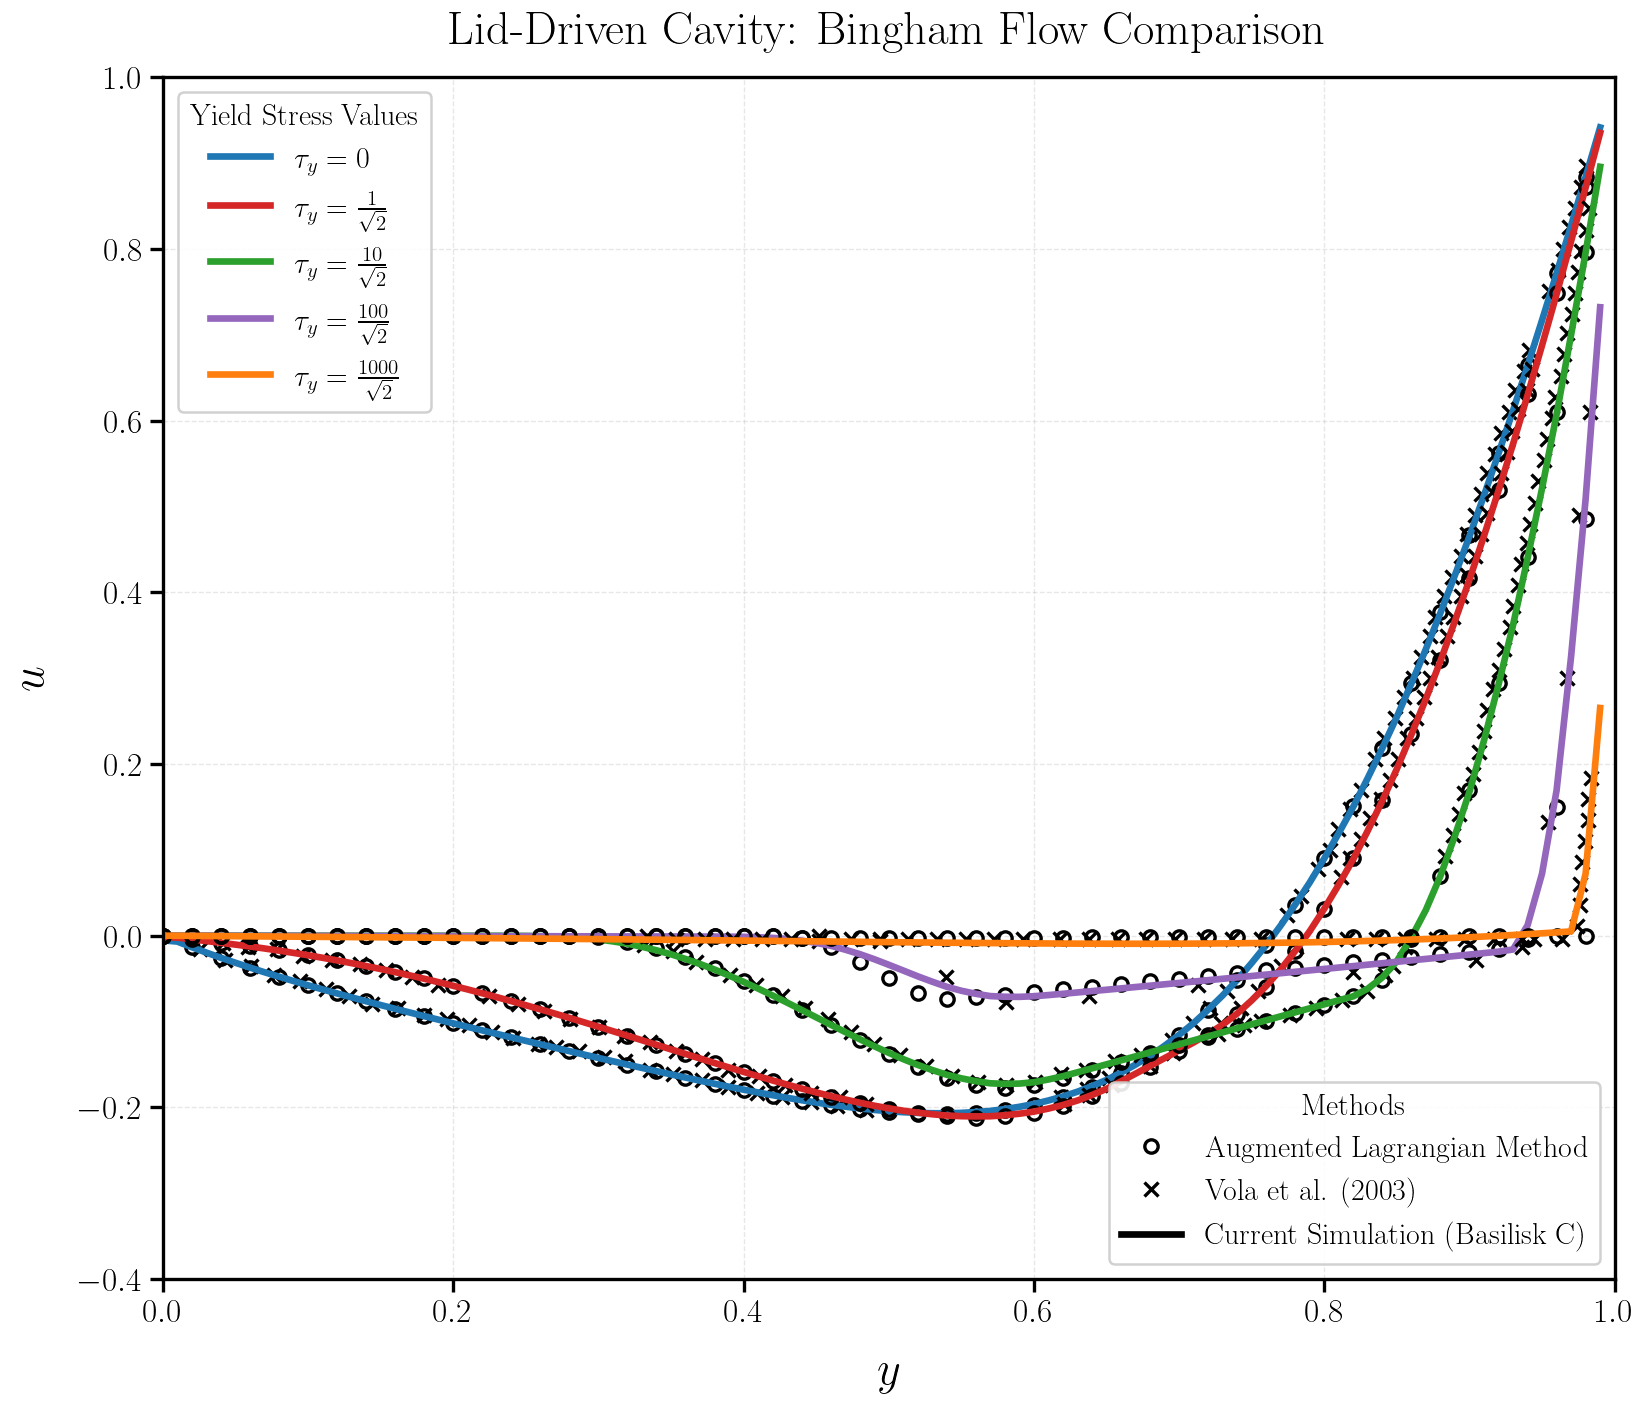

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import matplotlib.colors as mcolors
from scipy.io import loadmat

# Set global font parameters for publication quality
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 16,
    'mathtext.fontset': 'stix',
    'axes.labelsize': 24,
    'axes.titlesize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 18,
})

# Load data from .mat files
# - ALM: Augmented Lagrangian Method results from Popinet
pop_data = loadmat('2-LidDrivenCavity-Bingham-Data/Popinet_AugumentedLagrangian.mat')
ALM = pop_data['ALM'][0]

# - Vola: Benchmark results from Vola et al. (2003)
vola_data = loadmat('2-LidDrivenCavity-Bingham-Data/VolaEtAl.mat')
Vola = vola_data['Vola'][0]

# Define paths for Basilisk simulation data files
# - Each file corresponds to a different yield stress value
base_path = '../testCases/2-LidDrivenCavity-Bingham/tau'
filenames = [f"{base_path}{i}" for i in range(5)]
# - Define the actual yield stress values used in the simulations
tau_values = [0, 1/np.sqrt(2), 10/np.sqrt(2), 100/np.sqrt(2), 1000/np.sqrt(2)]

# Collect Basilisk data by running an external data extraction tool
# - The tool extracts velocity profiles along the vertical centerline
Bas = []
for fname in filenames:
    # Run external data extraction tool and capture its output
    result = subprocess.run(['./getData-Line', fname],
                            capture_output=True, text=True)
    y_values, u_values = [], []
    # Parse the output line by line
    for line in result.stderr.strip().split('\n'):
        parts = line.strip().split()
        if len(parts) >= 2:
            y, u = float(parts[0]), float(parts[1])
            # Adjust y-coordinate (shift by 0.5 to match reference data)
            y_values.append(y + 0.5)
            u_values.append(u)
    # Store the extracted data in our collection
    Bas.append({'y': np.array(y_values), 'u': np.array(u_values)})

# Create a high-quality figure for publication
fig, ax = plt.subplots(figsize=(14, 12), dpi=120)

# Define a custom color palette with highly distinct colors
# - These colors are chosen to be distinguishable for colorblind viewers
distinct_colors = [
    '#1f77b4',  # blue
    '#d62728',  # red
    '#2ca02c',  # green
    '#9467bd',  # purple
    '#ff7f0e',  # orange
]

# Configure plot aesthetics for better readability
ax.grid(True, linestyle='--', alpha=0.3, which='major')
ax.set_axisbelow(True)  # Place grid behind data

# Plot each dataset with improved visibility
nskip = 2  # Skip every other point for ALM data to reduce clutter
basilisk_lines = []

for i in range(len(filenames)):
    # Use a distinct color for each yield stress value
    color = distinct_colors[i]
    
    # Plot ALM data (black hollow circles)
    ax.plot(ALM[i]['y'][0][0][::nskip],
            ALM[i]['u'][0][0][::nskip],
            'o', color='black', markersize=8, mfc='none', mew=2,
            label='Augmented Lagrangian Method' if i == 0 else None)
    
    # Plot Vola data (black x markers)
    ax.plot(Vola[i]['y'][0][0],
            Vola[i]['u'][0][0],
            'x', color='black', markersize=8, mew=2,
            label='Vola et al. (2003)' if i == 0 else None)
    
    # Plot Basilisk data (colored lines with increased width)
    line, = ax.plot(Bas[i]['y'],
                   Bas[i]['u'],
                   '-', linewidth=4, color=color,
                   label=None)  # We'll add a single Basilisk entry to the legend later
    
    basilisk_lines.append(line)

# Create custom legend entries for the different methods
# - This approach allows for better control of legend appearance
lines = [plt.Line2D([0], [0], color='black', lw=0, marker='o', markersize=8, mfc='none', mew=2),
         plt.Line2D([0], [0], color='black', lw=0, marker='x', markersize=8, mew=2),
         plt.Line2D([0], [0], color='black', lw=4)]
labels = ['Augmented Lagrangian Method', 'Vola et al. (2003)', 'Current Simulation (Basilisk C)']

# Create tau value legend entries with distinct colors
tau_lines = [plt.Line2D([0], [0], color=distinct_colors[i], lw=4, ls='-') 
             for i, tau in enumerate(tau_values)]
# Format yield stress values with LaTeX for better appearance
tau_labels = [
    r'$\tau_y = 0$',
    r'$\tau_y = \frac{1}{\sqrt{2}}$',
    r'$\tau_y = \frac{10}{\sqrt{2}}$',
    r'$\tau_y = \frac{100}{\sqrt{2}}$',
    r'$\tau_y = \frac{1000}{\sqrt{2}}$'
]

# Create two separate legends for methods and yield stress values
# - First legend: different simulation methods
method_legend = ax.legend(lines, labels, loc='lower right', fontsize=18, 
                         framealpha=0.9, fancybox=True, title="Methods")
method_legend.get_frame().set_linewidth(1.5)
method_legend.get_title().set_fontsize(18)

# Add the method legend to the axes
ax.add_artist(method_legend)

# Second legend: different yield stress values
tau_legend = ax.legend(tau_lines, tau_labels, loc='upper left', fontsize=18, 
                       framealpha=0.9, fancybox=True, title="Yield Stress Values")
tau_legend.get_frame().set_linewidth(1.5)
tau_legend.get_title().set_fontsize(18)

# Set axis labels and title with improved formatting
ax.set_xlabel(r'$y$', fontsize=28, labelpad=15)
ax.set_ylabel(r'$u$', fontsize=28, labelpad=15)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([-0.4, 1.0])
ax.set_title('Lid-Driven Cavity: Bingham Flow Comparison', fontsize=28, pad=20)

# Make tick marks thicker and longer for better visibility
ax.tick_params(width=2, length=8, which='major')
ax.tick_params(width=1.5, length=5, which='minor')

# Make axis spines thicker for better visibility
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Ensure proper layout and save the figure
plt.tight_layout()
plt.savefig('2-LidDrivenCavity-Bingham-Data/2-LidDrivenCavity-Bingham-lid_driven_cavity_bingham_flow.pdf', bbox_inches='tight')
plt.show()